In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns

In [19]:
data = pd.read_csv("SIFI_full.csv")
data = data[(data["FlashType"] == 1) | (data["FlashType"] == 2)]
data = data[data["NrBeeps"] == 2]


<Axes: xlabel='correct_rel', ylabel='Count'>

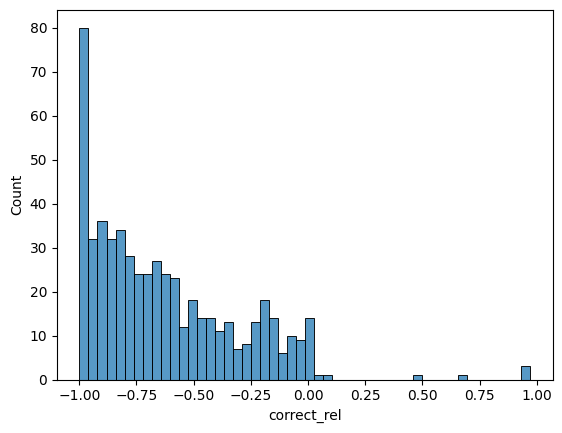

In [20]:
sns.histplot(data["correct_rel"], bins = 50)

In [4]:
correct_rel = data["correct_rel"]
rt_Cod = data["rt_Cod"]

In [5]:
data = data.drop(["participant_id","correct", "rt","correct_abs", "rt_abs", "correct_rel", "rt_Cod","rt_rel", "bl_correct","bl_rt", "CFF"], axis=1, index=None) # "Dist to V1, RH", "Dist to A1, RH", "Dist to A1, LH", "dist_ratio_R", "dist_ratio_L"

## Pipeline

In [6]:
num_features = data.columns[4:].to_list()
# ord_features = [data_flash1.columns[0]]
cat_features = data.columns[:3].to_list()

In [7]:
num_features

['Dist to A1, LH',
 'Dist to A1, RH',
 'Dist to V1, LH',
 'Dist to V1, RH',
 'dist_ratio_L',
 'dist_ratio_R']

In [8]:
whiten = Pipeline(
    steps = [("whiten", StandardScaler())]
)

cat_encoder = Pipeline(
    steps = [("cat_encoder", OneHotEncoder(handle_unknown="ignore"))]
)

# ord_encoder = Pipeline(
#     steps = [("cat_encoder", OrdinalEncoder())]
# )
interaction_sex_age = Pipeline([
    ('df_mapper', DataFrameMapper([
        (['sex'], OneHotEncoder(handle_unknown="ignore")),
        (['age'], StandardScaler())
    ], df_out=True)),
    ('interaction', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

interaction_flash_beeps = Pipeline([
    ('cat_encoder', OneHotEncoder(handle_unknown="ignore")),
    ('interaction', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("whiten", whiten, num_features),
        # ("ord_encoder", ord_encoder, cat_features),
        # ("cat_encoder", cat_encoder, cat_features)
    ]
)

In [12]:
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
svr = svm.SVR(kernel = "linear", epsilon = 0.2)
# svr_pipe = Pipeline([
#     ('preprocessor', ColumnTransformer([
#         ('interaction', interaction, ['FlashType', 'NrBeeps']),
#         ('whiten', whiten, num_features),
#         ('cat_encoder', cat_encoder, cat_features)
#     ])),
#     ('svr', svr)
# ])

rf = RandomForestRegressor(random_state=42)

# Define the pipeline with Random Forests
rf_pipe = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('interaction_flash_beeps', interaction_flash_beeps, ['FlashType', 'NrBeeps']),
        ('interaction_sex_age', interaction_sex_age, ['sex', 'age']),
        ('whiten', whiten, num_features),
        ('cat_encoder', cat_encoder, cat_features)
    ])),
    ('rf', rf)
])

gb = GradientBoostingRegressor(random_state=42)
gb_pipe = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('interaction_flash_beeps', interaction_flash_beeps, ['FlashType', 'NrBeeps']),
        ('interaction_sex_age', interaction_sex_age, ['sex', 'age']),
        ('whiten', whiten, num_features),
        ('cat_encoder', cat_encoder, cat_features)
    ])),
    ('gb', gb)
])

from sklearn.linear_model import QuantileRegressor
qr = QuantileRegressor(quantile=0.9, alpha=0, solver='highs')
qr_pipe = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('interaction_flash_beeps', interaction_flash_beeps, ['FlashType', 'NrBeeps']),
        ('interaction_sex_age', interaction_sex_age, ['sex', 'age']),
        ('whiten', StandardScaler(), num_features),
        ('cat_encoder', OneHotEncoder(handle_unknown="ignore"), cat_features)
    ])),
    ('qr', qr)
])

## 5-fold Cross-validation

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, correct_rel, test_size=0.25, random_state=42)

In [14]:
cat_feature_names = ["FlashType_1", "FlashType_2", "NrBeeps_1", "NrBeeps_2", "Sex_0", "Sex_1"]
feature_names = cat_feature_names + list(num_features)

In [17]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = cross_validate(rf_pipe, X_train, y_train, cv=cv, scoring=['r2', 'neg_mean_squared_error'], return_estimator =True, n_jobs = -1)

In [18]:
print("Mean R2 across folds: ", np.mean(cv_results['test_r2']))
print("Mean MSE across folds: ", np.mean(cv_results['test_neg_mean_squared_error']))

Mean R2 across folds:  0.6606521740388873
Mean MSE across folds:  -0.13713848522335467


In [19]:
coefs = pd.DataFrame(
    [
        est[-1].coef_[0] * est[:-1].transform(X_train.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_results["estimator"], cv.split(X_train, y_train))
    ],
    # columns = feature_names
)

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

NameError: name 'coefs' is not defined

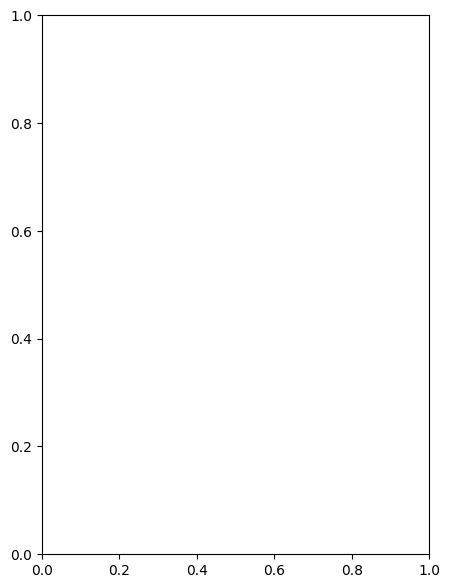

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

fig, ax = plt.subplots(figsize=(5, 7))
sns.boxplot(data=coefs.iloc[:, :100], orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
ax.set_ylabel("Features", fontsize = 15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
ax.tick_params(axis='x', labelsize= 12) 
ax.tick_params(axis='y', labelsize= 12) 
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")

## Check predictions

In [22]:
trained_svr = rf_pipe.fit(X_train, y_train)

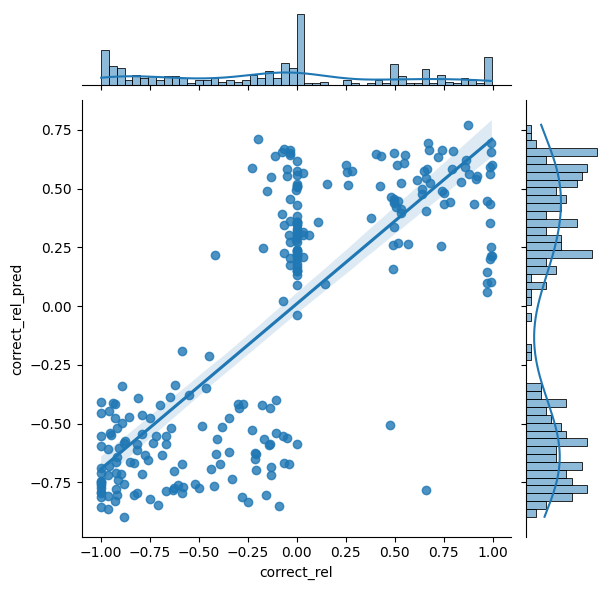

In [25]:
y_pred = trained_svr.predict(X_test)
test_pred_df = pd.DataFrame({"correct_rel": y_test, "correct_rel_pred": y_pred})
sns.jointplot(data=test_pred_df, x="correct_rel", y="correct_rel_pred", kind="reg", marginal_kws={'bins': 50})

<Axes: xlabel='correct_rel_pred', ylabel='Count'>

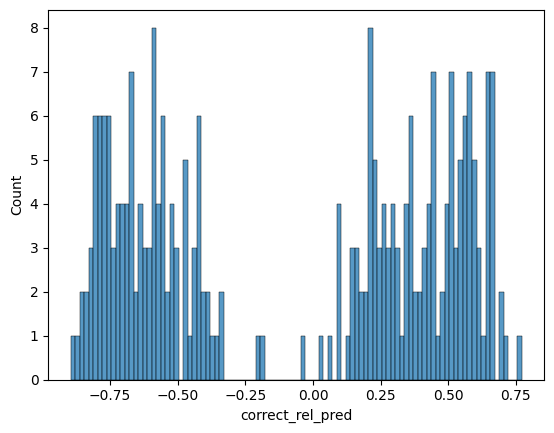

In [26]:
sns.histplot(test_pred_df["correct_rel_pred"], bins = 100)

## Model diagnostics

In [43]:
y_train_pred = trained_svr.predict(X_train)

In [44]:
from sklearn.metrics import r2_score

print("R squared: {}".format(r2_score(y_true=y_train,y_pred=y_train_pred)))

R squared: 0.6640580752124541


In [45]:
residuals = y_train.values-y_train_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 0.05283602570318633


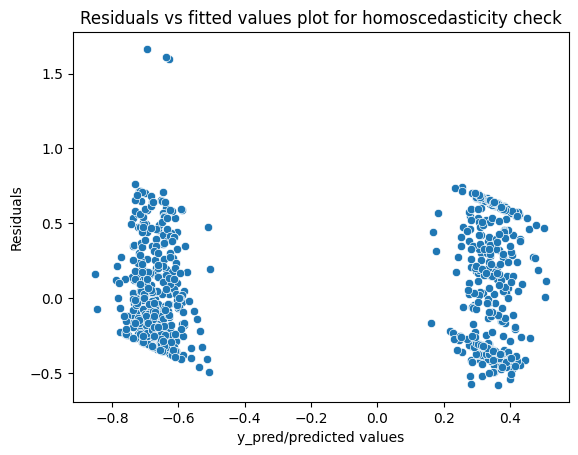

In [46]:
residuals_train = pd.DataFrame({"y_train_pred": y_train_pred, "residuals": residuals})

p = sns.scatterplot(residuals_train, x = "y_train_pred", y = "residuals")
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [47]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 1.0388048724004102), ('p-value', 0.3559351667869693)]

## Permutation feature importance

In [27]:
from sklearn.inspection import permutation_importance

perm_acc = permutation_importance(trained_svr, X_test, y_test,n_repeats=1000, random_state=42, n_jobs = -1)
perm_sorted_idx = perm_acc.importances_mean
perm_std = perm_acc.importances_std
null_dist_coefs = perm_acc.importances

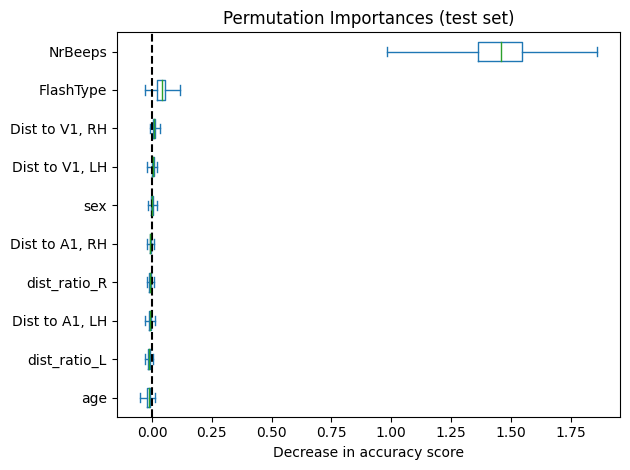

In [28]:
sorted_importances_idx = perm_acc.importances_mean.argsort()
importances = pd.DataFrame(
    perm_acc.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()